<a href="https://colab.research.google.com/github/jtwang1027/business_analysis/blob/master/lstm_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import layers

In [0]:
from keras.callbacks import EarlyStopping
import pandas as pd


In [0]:

data1=pd.read_csv('/content/drive/My Drive/feb_2020-dataset.csv')

#data1=data1.iloc[:4450,] #rounds it out and makes it easier to create sequences

In [145]:
data1.head()


,Hour,Gross Sales,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Month,date,Year
0,11,8.78,0,0,0,0,1,0,0,1,3,2019
1,12,96.74,0,0,0,0,1,0,0,1,3,2019
2,13,48.41,0,0,0,0,1,0,0,1,3,2019
3,14,79.26,0,0,0,0,1,0,0,1,3,2019
4,15,73.65,0,0,0,0,1,0,0,1,3,2019


The data needs to be cleaned. Each 'time step' should reflect some *real* time block, such as 1 working day or week. The store is typically open for 12hr per day, so We will drop data for days where there isn't a 12 hour open period.

In [164]:
num=data1.groupby(['Year','Month','date'])['Hour'].agg(['count'])
num.reset_index(inplace=True)
num.head()#count column shows how many hours we have data for in that day; #the mode is 12 hr
#alternatively we could do imputation instead of dropping the data

,Year,Month,date,count
0,2019,1,3,10
1,2019,1,4,8
2,2019,1,5,11
3,2019,1,6,9
4,2019,1,7,13


In [0]:
num=num[num['count']==12] #keep only dates where we have 12h of open time

In [0]:
data2=num.merge(data1, left_on=['Year', 'Month','date'], right_on=['Year', 'Month','date']) #one to many join

The new df (data2) is of the correct shape. For each date in num, there are 12 hours of data. The final df should have 12 x242= 2904

In [168]:
data2.shape

(2904, 13)

In [169]:
num.shape

(242, 4)

In [0]:
y=data2['Gross Sales'] 
X= data2.drop(['Gross Sales'],axis=1)
X=X.reindex(sorted(X.columns),axis=1) #put in alphabetical order
X.sort_values(['Year', 'Month','date','Hour'], ascending=[True]*4, inplace=True)

In [172]:
y.shape

(2904,)

In [0]:
newx=list(range(X.shape[0])) #artificial x-values to replace the raw date

In [175]:
# split into sample timesteps
samples = list()
length = 12 #length of each time step (or time sequence representing the 12 hours open each day)
timesteps= int(X.shape[0]/length) #num

for i in range(0,len(y),length):
	# grab from i to i + length
  sample = y[i:i+length]
  samples.append(sample)
print(len(samples))

242


This 242 represents the 242 work days (each day composed of a sequence of 12h) that we're training/testing on.

In [176]:
#reformat data into array and add 3rd filler dimension needed for lstm model
data=np.array(samples)

data=data.reshape((len(samples), length,1)) #length is the timestep size
data.shape


(242, 12, 1)

In [0]:
seq_length=length # length of a sequence

model = tf.keras.Sequential()
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(seq_length, dropout=0.2, recurrent_dropout=0.2, input_dim=1)) #input dim :# y columns
model.add(layers.Dense(seq_length))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor= EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#model.summary()

In [0]:
ntrain= int(0.8*len(y)) #number of rows to train on , 80-20 train-test split

ytrain=data[:ntrain]
ytest= data[18:]


In [0]:
xtrain=np.array(range(len(ytrain)))
xtrain=xtrain.reshape(len(xtrain),1,1)

xtest=np.array(range(len(ytest)))
xtest=xtest.reshape(len(xtest),1,1)

In [0]:
epoch=1000

history=model.fit(xtrain, ytrain, validation_data=(xtest, ytest),batch_size=5, callbacks=[monitor], verbose=2, epochs= epoch)

In [202]:
len(history.history['loss'])

366

Text(0, 0.5, 'MSE')

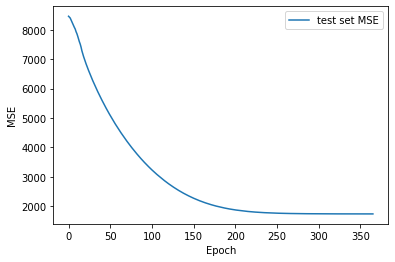

In [209]:
total_epochs=len(history.history['loss'])


#plt.plot(range(total_epochs), history.history['loss'])
plt.plot(range(total_epochs), history.history['val_loss'])
plt.legend(['test set MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [0]:
ypred=model.predict(xtest)
ypred_flat= [item for sublist in ypred for item in sublist]

ytest_flat= [item for sublist in ypred for item in sublist]
#len(ypred)

In [0]:
ypred_flat=ypred.reshape(ypred.shape[0]*ypred.shape[1],1)
ytest_flat=ytest.reshape(ytest.shape[0]*ytest.shape[1],1)

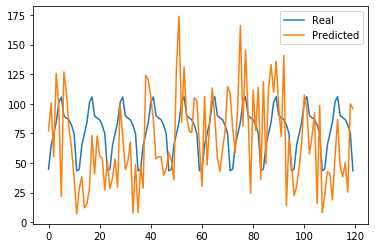

In [189]:
plt.plot(range(len(ypred_flat[:120])), ypred_flat[:120])
plt.plot(range(len(ypred_flat[:120])), ytest_flat[:120])
plt.legend(['Real','Predicted'])

#Conclusion
This model performance is comparable to the xgboost model in this case. It could be improved by adding additional factors. Or, the time sequence could be extended to a full week ( 12h/day x 7days) given there is an obvious trend over a 7 day period.